In [110]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [96]:
start_date = datetime.date(2011, 12, 25)
end_date = datetime.date(2023, 6, 21)
df = yf.download('NFLX', start = start_date, end = end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-12-27,10.328571,10.355714,10.028571,10.085714,10.085714,21940800
2011-12-28,10.074286,10.142857,9.795714,9.885714,9.885714,23597000
2011-12-29,9.854286,9.984286,9.658571,9.900000,9.900000,26163200
2011-12-30,9.872857,10.084286,9.832857,9.898571,9.898571,21809200
2012-01-03,10.040000,10.388571,10.018571,10.320000,10.320000,29213800


In [82]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-13,430.010010,437.269989,428.399994,435.730011,435.730011,7820500
2023-06-14,434.989990,447.329987,433.500000,440.859985,440.859985,8413100
2023-06-15,444.100006,448.649994,439.500000,445.269989,445.269989,7099900
2023-06-16,446.149994,447.510010,430.899994,431.959991,431.959991,8745500
2023-06-20,430.179993,440.000000,430.000000,434.700012,434.700012,4756000


In [97]:
df = df[['Adj Close']]
df.columns

Index(['Adj Close'], dtype='object')

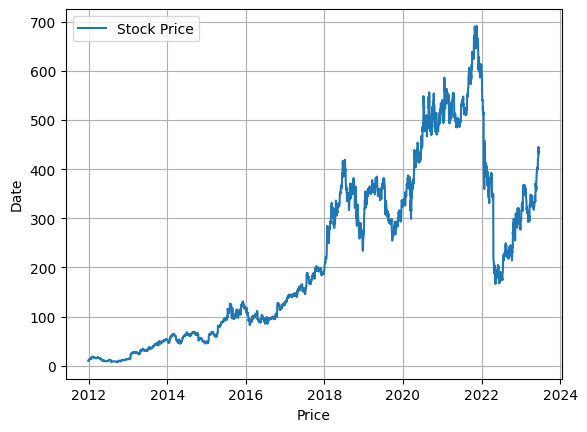

In [83]:
plt.plot(df['Adj Close'], label = 'Stock Price')
plt.xlabel("Price")
plt.ylabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [84]:
adf = adfuller(df['Adj Close'])
print("P-value: ",adf[1])
if adf[1] > 0.05:
    print("Nifty time series is non-stationary")
else:
    print("Nifty time series is stationary")

P-value:  0.6977991678573147
Nifty time series is non-stationary


In [85]:
adf = adfuller(df['Adj Close'].diff().dropna())
print("P-value: ",adf[1])
if adf[1] > 0.05:
    print("First differential of nifty time series is non-stationary")
else:
    print("First differential of nifty time series is stationary")

P-value:  4.731475266090393e-21
First differential of nifty time series is stationary


In [86]:
df['Adj Close diff'] = df['Adj Close'].diff()
df.dropna(inplace = True)

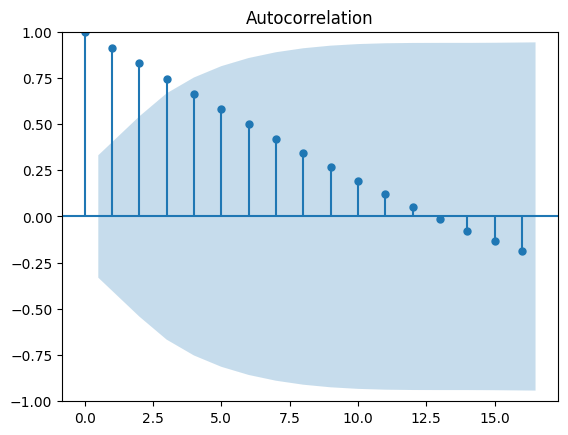

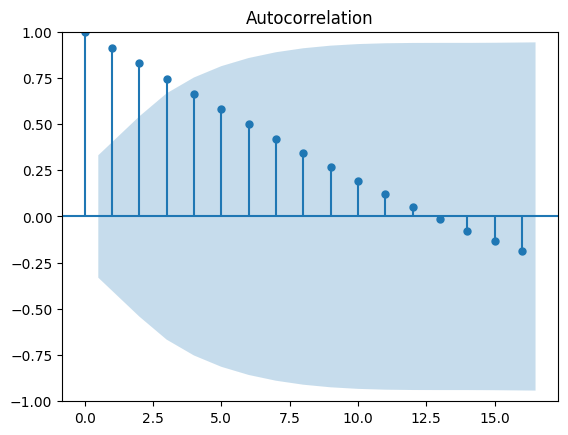

In [91]:
sm.graphics.tsa.plot_acf(sm.tsa.acf(df['Adj Close']))

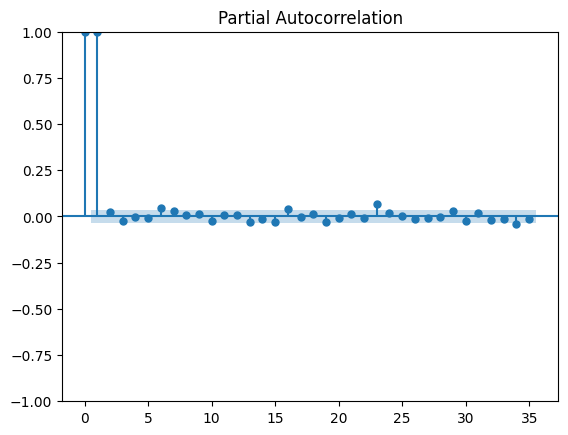

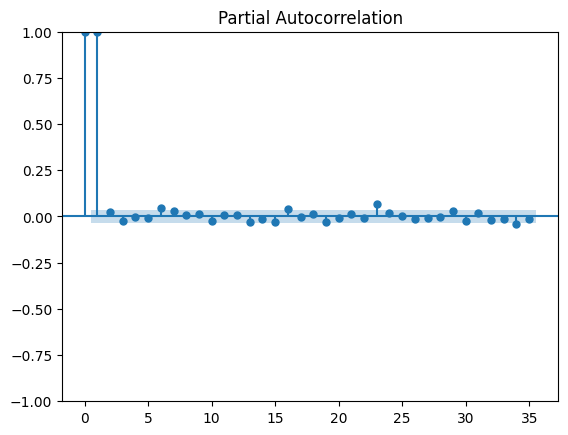

In [92]:
sm.graphics.tsa.plot_pacf(df['Adj Close'])

In [98]:
train_data = df.loc[:'2021-01-01']
test_data = df.loc['2021-01-01':]
train_data.shape, test_data.shape

((2269, 1), (619, 1))

In [144]:
model = ARIMA(train_data['Adj Close'], order = (2,1,0))

In [145]:
model_fit = model.fit()

In [146]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2269
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7267.438
Date:                Mon, 20 Nov 2023   AIC                          14540.876
Time:                        13:08:22   BIC                          14558.056
Sample:                             0   HQIC                         14547.144
                               - 2269                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0980      0.012     -8.145      0.000      -0.122      -0.074
ar.L2          0.0450      0.012      3.894      0.000       0.022       0.068
sigma2        35.5447      0.388     91.538      0.0

In [147]:
model_fit.params

ar.L1     -0.097978
ar.L2      0.045047
sigma2    35.544662
dtype: float64

So the model works out to \
$\hat{S_t} = -0.1025 S_{t-1}$

In [196]:
predicted_values = model_fit.predict()
residual_values = train_data['Adj Close'] - predicted_values
rmse = round(np.sqrt(np.mean(residual_values**2)), 2)
print("Root mean squared error on in-sample data: ", rmse)

Root mean squared error on in-sample data:  5.96


To predict values for test data, we need to find it in rolling way since the values are auto-correlated

In [204]:
# Forecasting the next value
forecast = model_fit.forecast()
forecast.iloc[0]

538.8657199608144

In [221]:
def predict_price_AR(data):

    model = ARIMA(data, order=(2, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    return forecast.iloc[0]

In [222]:
%%timeit

df['prediction'] = df['Adj Close'].rolling(window = train_data.shape[0]).apply(predict_price_AR)

41.9 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [229]:
df['prediction'] = df['prediction'].shift()
df.dropna(inplace = True)
df['error'] = df['prediction'] - df['Adj Close']

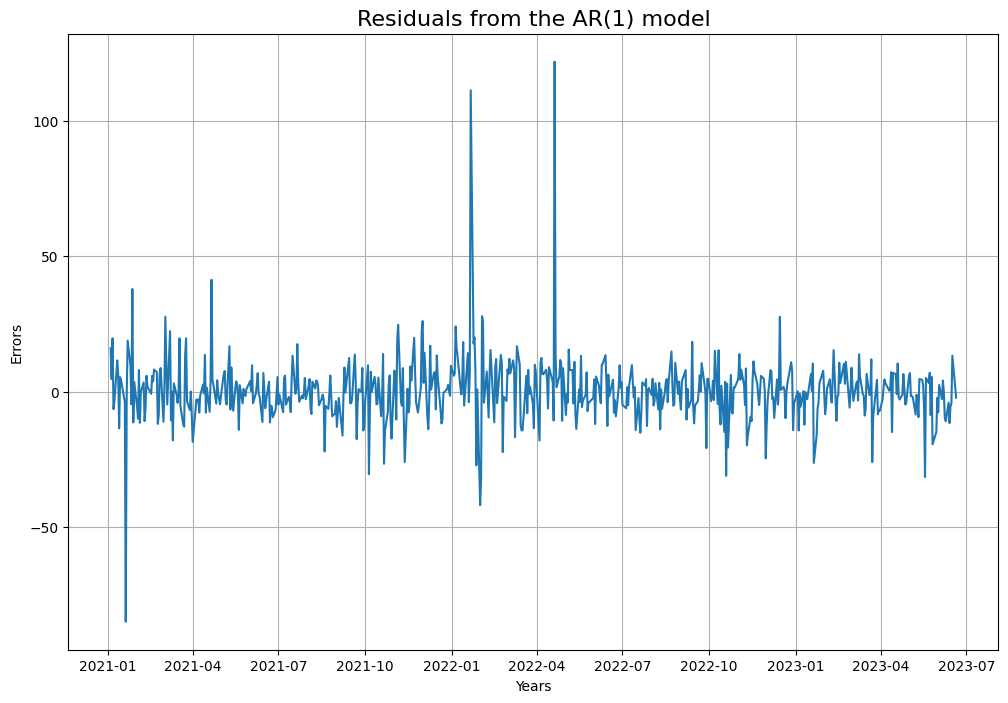

In [231]:
plt.figure(figsize=(12, 8))
plt.plot(df['error'])
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

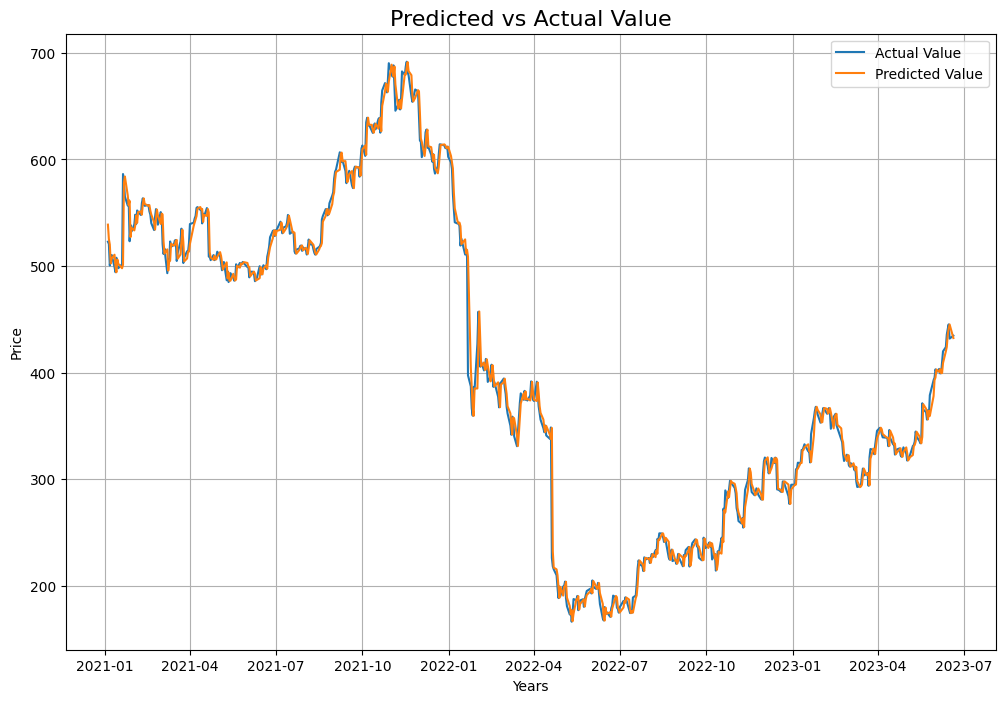

In [234]:
plt.figure(figsize=(12, 8))
plt.plot(df['Adj Close'], label = 'Actual Value')
plt.plot(df['prediction'], label = 'Predicted Value')
plt.title(f"Predicted vs Actual Value", fontsize=16)
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [236]:
rmse = round(np.sqrt(np.mean(df['error']**2)), 2)
print("Root mean squared error on out-sample data: ", rmse)

Root mean squared error on out-sample data:  12.15
